In [1]:
import pickle, os, torch
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score
from tqdm import tqdm

In [2]:
folder = 'results_sweep_zall_150122'

In [3]:
pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}')    

In [4]:
runs1=os.listdir(pointer)
runs=[] 
for run in runs1:
    if run[-1]!='2':
        runs.append(run) 
# total of 5 for each z
runs.sort()
runs

['Sage_vlarge_all_4t_zall_quantile_raw_trainandtest_frnlfw',
 'Sage_vlarge_all_4t_zall_quantile_raw_trainandtest_kappnu',
 'Sage_vlarge_all_4t_zall_quantile_raw_trainandtest_qbkwvj',
 'Sage_vlarge_all_4t_zall_quantile_raw_trainandtest_qozzif',
 'Sage_vlarge_all_4t_zall_quantile_raw_trainandtest_yahxau']

In [5]:
yss, preds = [], []
for k in [0,1,2,3,4]:


    results=pickle.load(open(osp.join(pointer,runs[k],'result_dict.pkl'), 'rb'))
    config=pickle.load(open(osp.join(pointer,runs[k],'construct_dict.pkl'), 'rb'))
    ys, pred, targets = results['ys']+9, results['pred']+9, config["data_params"]['targets']
    yss.append(ys)
    preds.append(pred)

In [6]:
ys=np.vstack(yss)
pred=np.vstack(preds)

In [7]:
from matplotlib.ticker import NullFormatter
from scipy import stats

def plot(ys, pred, z):
    target=r"log($M_{\odot}$)"
    # target=r"$v_{disk}$"

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.7
    bottom, height = 0.1, 0.7
    bottom_h = left_h = left + width
    # rect_Cbar = [0, bottom, 0.1, height]
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.15]
    rect_histy = [left_h, bottom, 0.15+0.06, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))
    # axCbar = plt.axes(rect_Cbar)
    axHist = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    axHistx.yaxis.set_major_formatter(nullfmt)
    axHisty.xaxis.set_major_formatter(nullfmt)

    bins=50
    l=0.01
    xt=0.05
    yt=0.8
    n_contour=4
    # the scatter plot:
    vals, x, y, hist =axHist.hist2d( ys, pred,bins=bins, range=[np.percentile(np.hstack([ys,pred]), [0+l,100-l]),
                                np.percentile(np.hstack([ys,pred]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
    X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
    axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white')
    axHist.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
    axHist.set(xlabel='SAM Truth',ylabel='GNN Prediction')
    axHist.legend()

    # now determine nice limits by hand:
    X, Y = X[0], Y.T[0]
    axHist.set_xlim((min(X), max(X)))
    axHist.set_ylim((min(Y), max(Y)))
    yhat=r'$\hat{y}$'
    pct=np.sum((ys[:,n]-pred[:,n])<0.2)/len(ys[:,n]-pred[:,n])

    r2=r2_score(ys,pred)
    rho = np.corrcoef(ys,pred)[0,1]
    axHist.text(xt,yt+0.04, f'Bias (mean(y-{yhat})) : {np.mean(ys-pred):.3f} dex', transform=axHist.transAxes)
    axHist.text(xt,yt, r'$\sigma$'+f'($\Delta${target}): '+f'{np.std(ys-pred):.3f} dex', transform=axHist.transAxes)
    axHist.text(xt,yt-0.04, '% within 0.2 dex:  '+f'{pct*100:.1f}', transform=axHist.transAxes)
    axHist.text(xt,yt-0.08, r'$R^2$ score:  '+f'{r2:.3f}', transform=axHist.transAxes)
    axHist.text(xt,yt-0.12, r'Pearson:  '+f'{rho:.3f}', transform=axHist.transAxes)



    # axHistx.hist(ys[:,n], bins=bins, histtype='step', density=1)
    # axy=axHisty.hist(pred[:,n], bins=bins, histtype='step', density=1, orientation='horizontal')
    ys_kde = stats.gaussian_kde(ys[:,n], 0.05)
    pred_kde = stats.gaussian_kde(pred[:,n], 0.05)
    axHistx.plot(X, ys_kde(X), 'k--', label=f'SAM {target}')
    axHisty.plot(pred_kde(Y), Y, "k-.", label=f'GNN {target}')
    axHistx.legend()
    axHisty.legend(loc='upper left')

    axHistx.set(title=f'Histogram of SAM-GNN {target} relationship')

    axHistx.set_xlim(axHist.get_xlim())
    axHisty.set_ylim(axHist.get_ylim())

    plt.colorbar(hist, ax=axHisty, location='right')

    plt.show()

In [8]:
#this can take forever minutes to load
case='vlarge_all_4t_zall_quantile_raw_trainandtest'
data=pickle.load(open(osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl'), 'rb'))

In [9]:
# xs=[]
# ys=[]
ls=[]
xf=[]
edge_index=[]
edge_attr=[]
for d in tqdm(data[int(len(data)*0.8):]):
#     xs.append(d.x.numpy())
    xf.append(d.x.numpy()[0])
#     ys.append(d.y.numpy())
    edge_index.append(d.edge_index)
    edge_attr.append(d.edge_attr)
    l=len(d.x.numpy())
    ls.append(l)
# xs=np.vstack(xs)
xf=np.vstack(xf)
# ys=np.vstack(ys)
ls=np.array(ls)
split=np.cumsum(ls)

100%|████████████████████████████████████████████████████████| 95339/95339 [00:02<00:00, 43498.37it/s]


In [10]:
zs, ids = np.unique(xf[:,0], return_counts=1)

In [11]:
ids, zs

(array([23626, 25313, 24640, 21760]),
 array([0.8231716, 1.2867019, 1.684464 , 5.1993375], dtype=float32))

In [12]:
len(ys)/95339, len(ys)

(5.0, 476695)

In [13]:
idx=np.array([0, 21760, 46400, 71713, 95339])
zs=[0,0.5,1,2]
idxx=95339

In [14]:
stds=[]
for j in range(5):
    print('-----------------')
    for i in range(4):
        print(idx)
        print(zs[i])
        print(np.std(ys[:,0][idx[i]:idx[i+1]]-pred[:,0][idx[i]:idx[i+1]]))
        stds.append(np.std(ys[:,0][idx[i]:idx[i+1]]-pred[:,0][idx[i]:idx[i+1]]))
        
    idx+=idxx


-----------------
[    0 21760 46400 71713 95339]
0
0.08338201
[    0 21760 46400 71713 95339]
0.5
0.07162407
[    0 21760 46400 71713 95339]
1
0.07304295
[    0 21760 46400 71713 95339]
2
0.07324439
-----------------
[ 95339 117099 141739 167052 190678]
0
0.085787185
[ 95339 117099 141739 167052 190678]
0.5
0.067763686
[ 95339 117099 141739 167052 190678]
1
0.06892629
[ 95339 117099 141739 167052 190678]
2
0.0718983
-----------------
[190678 212438 237078 262391 286017]
0
0.08337812
[190678 212438 237078 262391 286017]
0.5
0.068363704
[190678 212438 237078 262391 286017]
1
0.07156477
[190678 212438 237078 262391 286017]
2
0.07324377
-----------------
[286017 307777 332417 357730 381356]
0
0.082364954
[286017 307777 332417 357730 381356]
0.5
0.069279924
[286017 307777 332417 357730 381356]
1
0.06974628
[286017 307777 332417 357730 381356]
2
0.07364331
-----------------
[381356 403116 427756 453069 476695]
0
0.08430968
[381356 403116 427756 453069 476695]
0.5
0.06832425
[381356 403116 4

In [181]:
scats=np.split(np.array(stds), 5)
med=np.median(scats, axis=0)
errs=np.percentile(scats, [16,84], axis=0)

In [182]:
errs

array([[0.08301338, 0.06812245, 0.06933106, 0.07140719],
       [0.08484158, 0.07012382, 0.07209692, 0.073388  ]])

In [183]:
errs=errs-np.array([med,med])
errs=np.abs(errs)

In [184]:
errs_i = np.array([0.0024627, 0.00194627, 0.00250013, 0.00145816])
med_i = np.array([0.08041992, 0.06989912, 0.07245081, 0.07275824])
pct_i = np.array([[0.07819011, 0.06965013, 0.07050285, 0.07174915],
                  [0.08331451, 0.07200135, 0.07540134, 0.07406328]])

med_unknown = [0.073137235, 0.06762478, 0.073827946, 0.070901915]
pct_unknown = np.array([[0.072144235, 0.06837109, 0.072918432, 0.069981860],
                        [0.074529182, 0.06691952, 0.075929471, 0.072351664]])

err_unknown = [ 0.0013167991,  0.00068282936, 0.0015762349, 0.000983736]

In [185]:
pct_i=pct_i-np.array([med_i,med_i])
pct_unknown=pct_unknown-np.array([med_unknown,med_unknown])
pct_i=np.abs(pct_i)
pct_unknown=np.abs(pct_unknown)

In [186]:
med_i, pct_i

(array([0.08041992, 0.06989912, 0.07245081, 0.07275824]),
 array([[0.00222981, 0.00024899, 0.00194796, 0.00100909],
        [0.00289459, 0.00210223, 0.00295053, 0.00130504]]))

In [187]:
# (0.073137235, 0.0013167991) (-0.011)

# (0.06762478, 0.00068282936) (0.011)

# (0.074327946, 0.0015762349) (0.008)

# (0.10838483, 0.005107765) (-0.11)

##individually trained stuff
# mus_i2, errs_i2 = [0.20579257, 0.1560455, 0.08998191], [0.040139306, 0.01847149, 0.025444217]

In [188]:
ticks=[0,0.25,0.5,0.75,1, 1.5, 1.75,2]
zs2=[0.25,0.75,1.5,1.75]

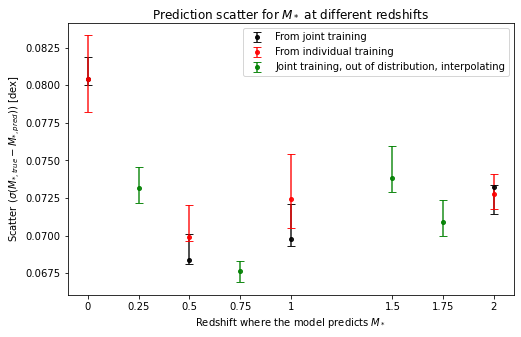

In [200]:
fig, ax =plt.subplots(figsize=(8,5))
ax.errorbar(zs, med, yerr=errs, color='k', fmt='.', markersize=8,
            capsize=4, ecolor='k', alpha=0.9, label='From joint training')

ax.errorbar(zs, med_i, yerr=pct_i, color='r', fmt='.', markersize=8,
            capsize=4, ecolor='r', alpha=0.9, label='From individual training')

ax.errorbar(zs2, med_unknown, yerr=pct_unknown, color='g', fmt='.', markersize=8,
            capsize=4, ecolor='g', alpha=0.9, label='Joint training, out of distribution, interpolating')


# for i, (mu, err) in enumerate(zip(mus_i2, errs_i2)):
#     r = random.random()
#     b = random.random()
#     g = random.random()
#     color = (r, g, b)
#     ax.errorbar(1.75, mu, yerr=err, color=color, fmt='.', markersize=8,
#                 capsize=4, ecolor=color, alpha=0.9, label=f'Train at {zs[1:][i]}, test at 1.75')
# # ax.plot(percentiles+0.5, ml, 'k--', alpha=0.4)
ax.set(xlabel=r'Redshift where the model predicts $M_*$', ylabel=r'Scatter ($\sigma (M_{*,true}-M_{*,pred})$) [dex]')
ax.set(title=r'Prediction scatter for $M_*$ at different redshifts')
ax.set(xticks=ticks, xticklabels=ticks)
ax.legend()
fig.savefig('../paper_figures/generalization_interpolate.png')

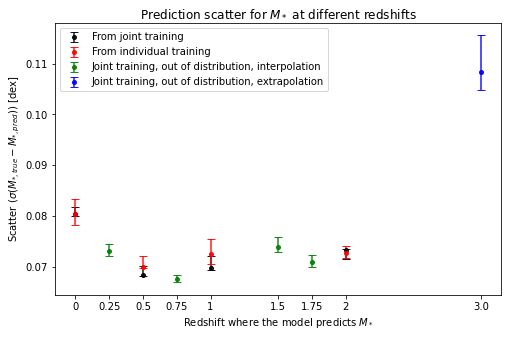

In [199]:
fig, ax =plt.subplots(figsize=(8,5))
ax.errorbar(zs, med, yerr=errs, color='k', fmt='.', markersize=8,
            capsize=4, ecolor='k', alpha=0.9, label='From joint training')

ax.errorbar(zs, med_i, yerr=pct_i, color='r', fmt='.', markersize=8,
            capsize=4, ecolor='r', alpha=0.9, label='From individual training')

ax.errorbar(zs2, med_unknown, yerr=pct_unknown, color='g', fmt='.', markersize=8,
            capsize=4, ecolor='g', alpha=0.9, label='Joint training, out of distribution, interpolation')

ax.errorbar(3, 0.10838483, yerr=[[0.10838483-0.1048174], [0.1155620-0.10838483]], color='b', fmt='.', markersize=8,
            capsize=4, ecolor='b', alpha=0.9, label='Joint training, out of distribution, extrapolation')

# for i, (mu, err) in enumerate(zip(mus_i2, errs_i2)):
#     r = random.random()
#     b = random.random()
#     g = random.random()
#     color = (r, g, b)
#     ax.errorbar(1.75, mu, yerr=err, color=color, fmt='.', markersize=8,
#                 capsize=4, ecolor=color, alpha=0.9, label=f'Train at {zs[1:][i]}, test at 1.75')
# # ax.plot(percentiles+0.5, ml, 'k--', alpha=0.4)
ax.set(xlabel=r'Redshift where the model predicts $M_*$', ylabel=r'Scatter ($\sigma (M_{*,true}-M_{*,pred})$) [dex]')
ax.set(title=r'Prediction scatter for $M_*$ at different redshifts')
ax.set(xticks=ticks+[3.0], xticklabels=ticks+[3.0])
ax.legend()
fig.savefig('../paper_figures/generalization_extrapolate.png')